In [59]:
#!/usr/bin/env python

import numpy as np
import import_ipynb
#import numpy.linalg as LA
#import LMM as lmm
import random
import time
import os
import pandas as pd
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from statsmodels.graphics.api import abline_plot
import seaborn as sns
from scipy import stats
import matplotlib.patches as mpatches
np.random.seed(10)


In [60]:

#### import the immune subpopulation of the rat samples
data = sc.read('/home/delaram/scLMM/input_data_designMat/inputdata_rat_set1_countData_2.h5ad') ## attributes removed
data.var_names_make_unique()
# a.obs['orig.ident'].head()
### renaming the meta info column names: https://github.com/theislab/scvelo/issues/255
data.__dict__['_raw'].__dict__['_var'] = data.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

data_numpy = data.X.toarray()
cell_sums = np.sum(data_numpy,axis=1) # row sums - library size
gene_sums = np.sum(data_numpy,axis=0) # col sums - sum reads in a gene
gene_vars = np.var(data_numpy, axis=0)
data_numpy = data_numpy[:,gene_sums != 0]

data_sub = data_numpy
strain = data.obs.strain
#### sample metadata
y_cluster =data.obs.cluster 
y_sample = data.obs.sample
y_strain = np.zeros((strain.shape[0]))
y_sample = data.obs[['sample']].squeeze()
y_strain_str = data.obs[['strain']].squeeze()

for i in range(len(data.obs.strain)):
    if data.obs.strain[i] != 'DA':
        y_strain[i] = 1

## working with the rat data
num_cells = data_sub.shape[0]
num_genes = data_sub.shape[1]
num_vars = 2 # number of variables in the design matrix - strain

y = data_numpy
### design matrix - strain
x = y_strain
### add a column of ones to the design matrix
x = sm.add_constant(x)


In [61]:
print("num_cells", num_cells)
print("num_genes", num_genes)
print(y.shape)

num_cells 23036
num_genes 1000
(23036, 1000)


In [57]:
#### could save residual deviance as well since I don't know how it's calculated

variable_names = ['coefficient', 'pvalue', 'fittedvalues', 'deviance', 'null_deviance']
### read the csv file in a loop and save the results to a dictionary
variable_dict = {}
for i in range(len(variable_names)):
    variable_dict[variable_names[i]] = pd.read_csv('GLM_FA_res/X_strain_Intercept/' + variable_names[i] + '.csv', header=None)
    print(variable_names[i] + ' read')

coefficient read
pvalue read
fittedvalues read
deviance read
null_deviance read


In [62]:
print(variable_dict['coefficient'].shape)
print(variable_dict['pvalue'].shape)
print(variable_dict['fittedvalues'].shape)
print(variable_dict['deviance'].shape)
print(variable_dict['null_deviance'].shape)

i = 100
null_deviance_i = variable_dict['null_deviance'].iloc[i,0]
deviance_i = variable_dict['deviance'].iloc[i,0]
fittedvalues_i = variable_dict['fittedvalues'].iloc[i,:]
coefficient_i = variable_dict['coefficient'].iloc[i,0]
pvalue_i = variable_dict['pvalue'].iloc[i,0]
y_i = y[:,i]

model = sm.GLM(y[:, i], x, family=sm.families.Poisson())
result = model.fit()

print(y_i.shape)
print(fittedvalues_i.shape)

(1000, 2)
(1000, 2)
(1000, 23036)
(1000, 1)
(1000, 1)
(23036,)
(23036,)


In [63]:
fittedvalues = variable_dict['fittedvalues'].T
response_residual = y - fittedvalues
resid_pearson = (y - fittedvalues)/np.sqrt(result.family.variance(fittedvalues)) ## variance function of the poisson family is power?
Pearson_Chi_Squared = sum(resid_pearson**2)

In [64]:
### Response residual - array
# The response residuals are defined as endog - fittedvalues
response_residual_i = y_i - fittedvalues_i
print('response residual: ', response_residual_i[:3])

## Working residual - response residuals scaled by the derivative of the inverse of the link function
# The working residuals are defined as resid_response/link’(mu) - then why is mu=yhat instead of mu=e^yhat? 
resid_working_i = response_residual_i/result.family.link.deriv(fittedvalues_i) ## derivatives of the link function
print('working residual manual: ', resid_working_i[:3])


### The Pearson residuals - response residuals scaled by the square root of the variance function
# (endog - mu)/sqrt(VAR(mu)) where VAR is the distribution specific variance function
resid_pearson_i = (y_i - fittedvalues_i)/np.sqrt(result.family.variance(fittedvalues_i)) ## variance function of the poisson family is power?
print('pearson residual manual: ', resid_pearson_i[:3])


### calculate the Pearson’s Chi-Squared statistic 
# the sum of the squares of the Pearson residuals.
Pearson_Chi_Squared_i = sum(resid_pearson_i**2)
print('Pearson_Chi_Squared manual: ', Pearson_Chi_Squared_i)


### calculate the BIC - float
# BIC : deviance - df_resid * log(nobs)
BIC_i = deviance_i - result.df_resid * np.log(y.shape[1])
print('BIC manual: ', BIC_i)


### calculate the AIC - float
# AIC: aike Information Criterion
# -2 * llf + 2 * (df_model + 1)
## df_model: rank of the regression matrix excluding the intercept:  df_model = k_exog - 1 = 0 is only strain is included
df_model = num_vars - 1
AIC_i = deviance_i + 2 * (df_model + 1)
print('AIC manual: ', AIC_i)


### calculate the pseudo R-squared - float
pseudo_rsquared_i = 1 - abs(deviance_i/null_deviance_i)
print('pseudo R-squared manual: ', pseudo_rsquared_i)
#print('pseudo R-squared is: ', result.pseudo_rsquared)


response residual:  0   -0.000146
1   -0.000146
2   -0.000146
Name: 100, dtype: float64
working residual manual:  0   -2.120326e-08
1   -2.120326e-08
2   -2.120326e-08
Name: 100, dtype: float64
pearson residual manual:  0   -0.012067
1   -0.012067
2   -0.012067
Name: 100, dtype: float64
Pearson_Chi_Squared manual:  9687846.999709299
BIC manual:  -159044.11795432394
AIC manual:  73.1171417506078
pseudo R-squared manual:  0.0021800966658066523


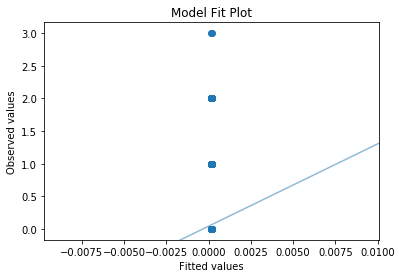

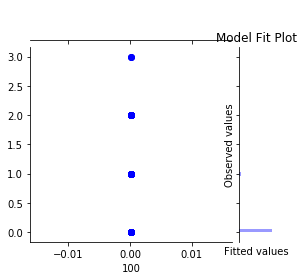

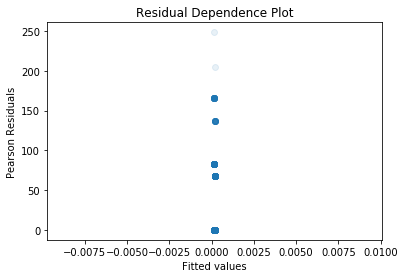

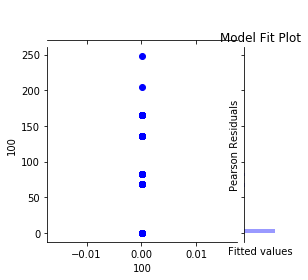

In [65]:

plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots()
ax.scatter(fittedvalues_i, y[:, i])
line_fit = sm.OLS(y_i, sm.add_constant(fittedvalues_i, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax, alpha=0.5)

ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values')

sns.jointplot(fittedvalues_i, y[:, i], kind='scatter', stat_func=None, color='b', height=4)
sns.set_context(font_scale=0.9)                                                  
plt.title('Model Fit Plot')
plt.xlabel('Fitted values')
plt.ylabel('Observed values')
## change the size of the text in plot
plt.rc('font', size=10)

fig, ax = plt.subplots()
resid_pearson_i = resid_pearson[i]
ax.scatter(fittedvalues_i, resid_pearson_i, alpha=0.1)
#ax.hlines(0, 0, 7)
#ax.set_xlim(0, 7)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

sns.jointplot(fittedvalues_i, resid_pearson_i, kind='scatter', stat_func=None, color='b', height=4)
sns.set_context(font_scale=0.9)                                                  
plt.title('Model Fit Plot')
plt.xlabel('Fitted values')
plt.ylabel('Pearson Residuals')
## change the size of the text in plot
plt.rc('font', size=10)
plt.show()




In [66]:
def plot_pca(pca, num_components_to_plot, title='PCA of the data matrix'):
    
    for i in range(1, num_components_to_plot):
        ## color PCA based on strain
        plt.figure()
        plt.scatter(pca.components_[0], pca.components_[i], c=strain_color, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.title(title)
        plt.legend(handles=[mpatches.Patch(color='springgreen', label='LEW'),
                            mpatches.Patch(color='hotpink', label='DA')])
        plt.show()

        ## color PCA based on cluster
        plt.figure()
        plt.scatter(pca.components_[0], pca.components_[i], c=c, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.title(title)
        plt.show()

        ###  ## color PCA based on sample
        plt.figure()
        plt.scatter(pca.components_[0], pca.components_[i], c=sample_color, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.legend(handles=[mpatches.Patch(color='palegreen', label='LEW_01'),
                            mpatches.Patch(color='forestgreen', label='LEW_02'),
                            mpatches.Patch(color='pink', label='DA_01'),
                            mpatches.Patch(color='orchid', label='DA_02')], loc='best')
        plt.show()


    # plot the variance explained by each PC
    plt.figure()
    plt.plot(pca.explained_variance_ratio_)
    plt.title('Variance explained by each PC')
    plt.xlabel('PC')
    plt.ylabel('Variance explained')
    plt.show()



#### generating the list of colors for clusters
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(y_cluster)))) ### set the color for each cluster
my_color = {}
### define a dictionary to map the cluster number to the color
list_levels = list(set(y_cluster))
for i in range(len(set(list_levels))):
    my_color[list_levels[i]] = colors[i]
### generate a list containing the corresponding color for each cluster
c = [my_color[y_cluster[i]] for i in range(len(y_cluster))]


### generating the list of colors for samples
my_color = {'LEW_01': 'palegreen', 'LEW_02':'forestgreen', 'DA_01':'pink', 'DA_02':'orchid'}
### generate a list containing the corresponding color for each sample
sample_color = [my_color[y_sample[i]] for i in range(len(y_sample))]

my_color = {'LEW': 'springgreen', 'DA':'hotpink'}
strain_color = [my_color[y_strain_str[i]] for i in range(len(y_strain_str))]

### applying PCA to the data matrix
num_components = 5


3.0054235881243834
len of pca components:  23036


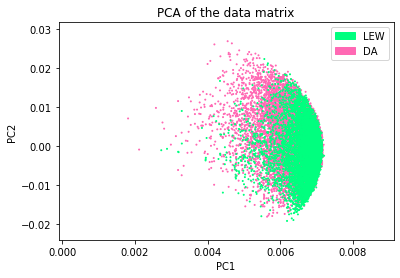

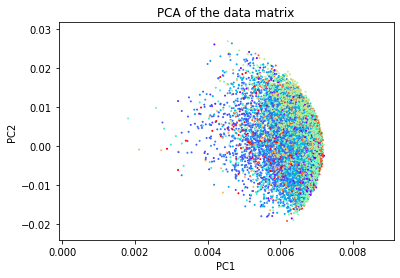

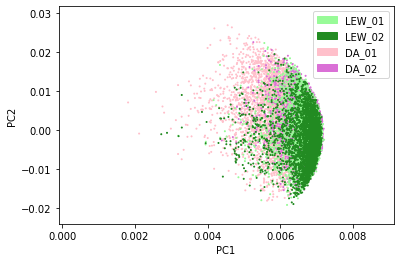

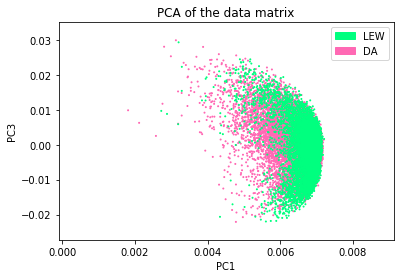

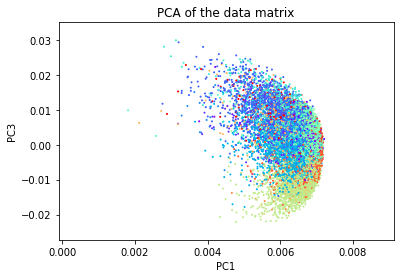

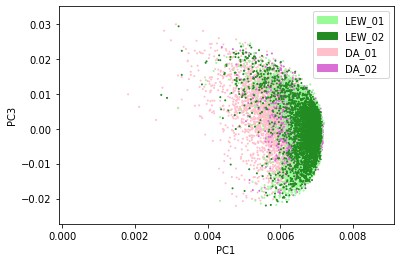

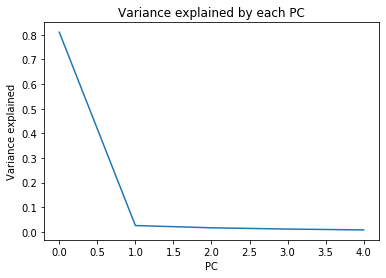

In [67]:
### using PCA directly
#pca = PCA(n_components=20)
#pca.fit(y.T)

### using pipeline to scale the data first
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pipeline.fit_transform(y.T)
pca = pipeline.named_steps['pca']

#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)
print(pca.noise_variance_)
print('len of pca components: ', len(pca.components_[0]))

plot_pca(pca, 3, title='PCA of the data matrix')


noise_variance:  1.9085993100495613


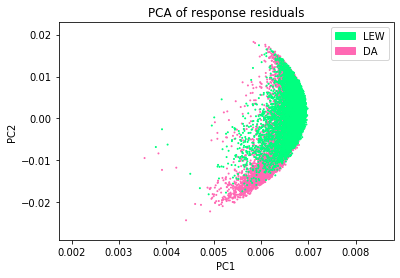

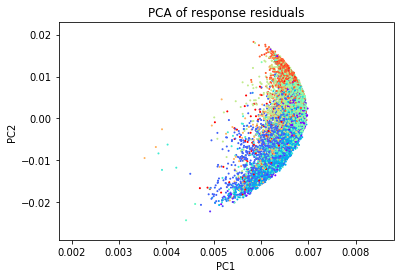

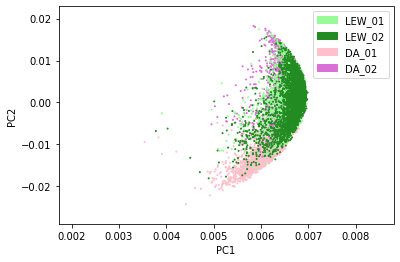

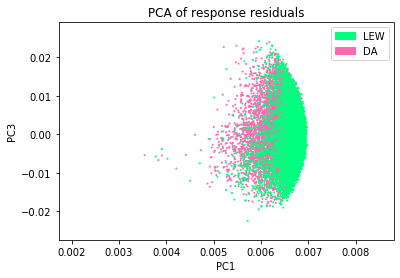

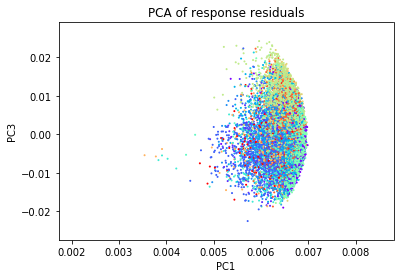

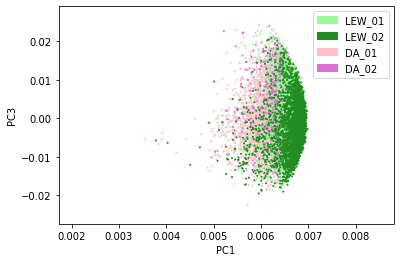

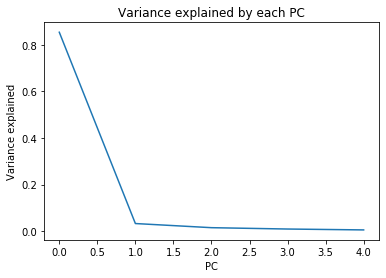

In [68]:

### applying PCA to the response residuals
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pipeline.fit_transform(response_residual.T)
pca = pipeline.named_steps['pca']

#pca = PCA(n_components=20)
#pca.fit(resid_response)

#print('explained variance ratio: ', pca.explained_variance_ratio_)
#print('singular values: ', pca.singular_values_)#
print('noise_variance: ', pca.noise_variance_)

plot_pca(pca, 3, title='PCA of response residuals')

noise_variance:  8.998580707854261


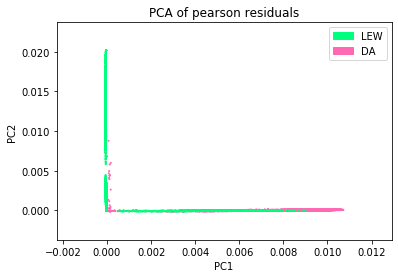

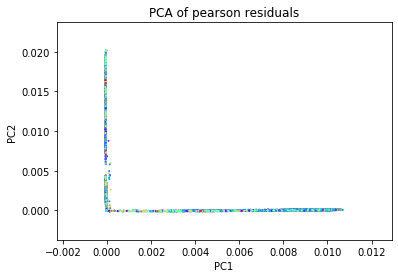

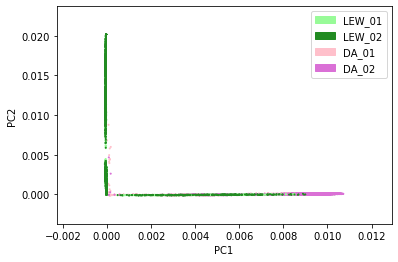

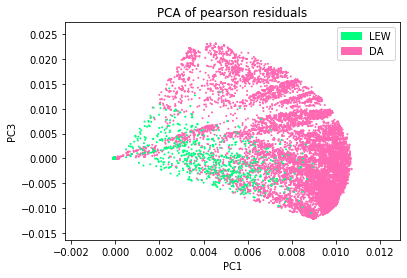

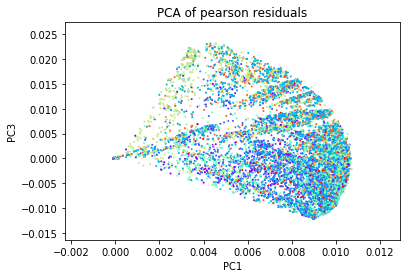

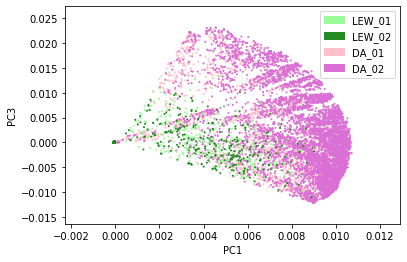

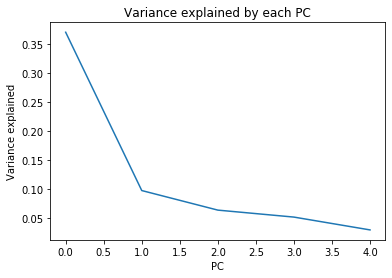

In [69]:
### applying PCA to the pearson residuals
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pipeline.fit_transform(resid_pearson.T)
pca = pipeline.named_steps['pca']

#pca = PCA(n_components=20)
#pca.fit(resid_response)

#print('explained variance ratio: ', pca.explained_variance_ratio_)
#print('singular values: ', pca.singular_values_)#
print('noise_variance: ', pca.noise_variance_)

plot_pca(pca, 3, title='PCA of pearson residuals')


In [74]:
### check the head of the pvalue matrix inside the variable dictionary
pvalue = variable_dict['pvalue']
print(pvalue.head())

### check the colnames of data matrix
gene_names = data.var_names[gene_sums != 0]
gene_names = gene_names[gene_idx]
gene_names = pd.DataFrame(gene_names) ## convert gene names to a pandas dataframe
### concatenate the gene names with the pvalues
pvalue_gene = pd.concat([pvalue, gene_names], axis=1)

print(pvalue_gene.head())
### get the coefficients info from the variable dictionary
coefficients = variable_dict['coefficient']
### convert the coefficients to a pandas dataframe
coefficients = pd.DataFrame(coefficients)
### concatenate the coefficients with the pvalues and gene names
model_info = pd.concat([pvalue_gene, coefficients], axis=1)
model_info.columns = ['pvalue', 'gene', 'coefficients']

print(model_info.head())
model_info = model_info.sort_values(by='pvalue', ascending=True)
model_info = model_info.sort_values(by='coefficients', ascending=False)
model_info.head(30)

               0         1
0   1.608023e-21  0.999106
1   4.490863e-80  0.049715
2  1.041590e-257  0.172784
3   0.000000e+00  0.687514
4   0.000000e+00  0.000363
               0         1               0
0   1.608023e-21  0.999106           Senp6
1   4.490863e-80  0.049715  AABR07005031.2
2  1.041590e-257  0.172784            Lcn5
3   0.000000e+00  0.687514           Arl5a
4   0.000000e+00  0.000363           Tsta3


ValueError: Length mismatch: Expected axis has 5 elements, new values have 3 elements